In [419]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import ttest_ind

In [420]:
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [421]:
# Replace 0's with NaN
df['Glucose'] = df['Glucose'].replace(0, np.nan) # 1 observation med 0
df['BloodPressure'] = df['BloodPressure'].replace(0, np.nan) # 0 m 0
df['SkinThickness'] = df['SkinThickness'].replace(0, np.nan) # 0 m 0
df['Insulin'] = df['Insulin'].replace(0, np.nan) #236 observationer med 0
df['BMI'] = df['BMI'].replace(0, np.nan) # 1 med 0
df['Age'] = df['Age'].replace(0, np.nan) # 0 m 0
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].replace(0,np.nan)
# Remove NaN rows in data
df_no_nan = df.dropna()
df_no_nan.to_csv('diabetes_removed_nan.csv', index=False)

new_df = pd.read_csv("diabetes_removed_nan.csv")

display(new_df.head())
len(new_df) #originalt: 768, efter alle: 392

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
1,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
2,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
3,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
4,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1


392

In [422]:
# Standardize data
# Which coloumns to drop:
drop_coloumns = ['Outcome']#, 'DiabetesPedigreeFunction'

features = [col for col in df.columns if col not in [col for col in drop_coloumns]]

x = new_df.loc[:, features].values
x = StandardScaler().fit_transform(x)
len(x.T)

8

Pregnancies
min 0 
max 17 
mean 3.3010204081632653 
median 2.0 
var 10.286937734277386
Low outliers: 0 High outliers: 22 Tot: 22 Percent: 0.056


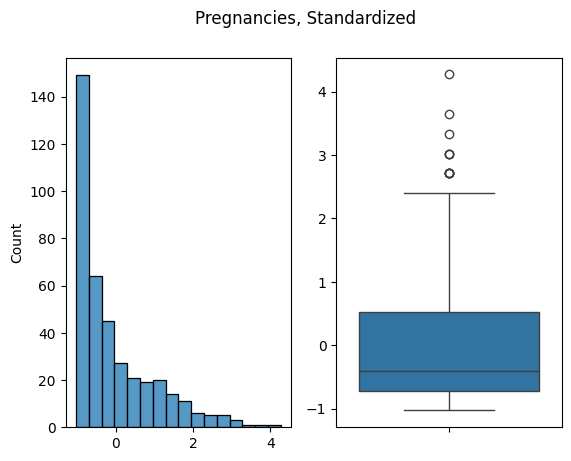

Glucose
min 56.0 
max 198.0 
mean 122.62755102040816 
median 119.0 
var 949.9582205331112
Low outliers: 0 High outliers: 11 Tot: 11 Percent: 0.028


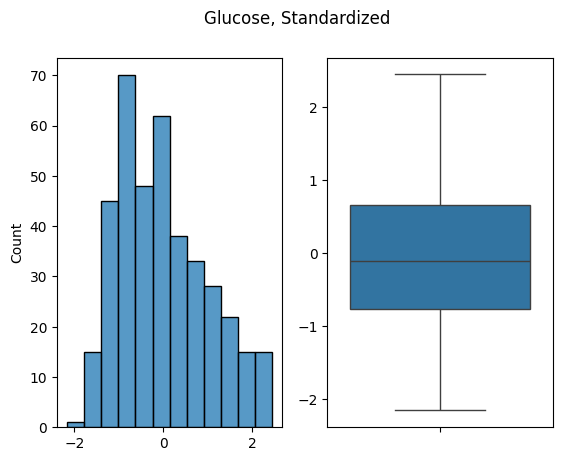

BloodPressure
min 24.0 
max 110.0 
mean 70.66326530612245 
median 70.0 
var 155.7539566847147
Low outliers: 8 High outliers: 8 Tot: 16 Percent: 0.041


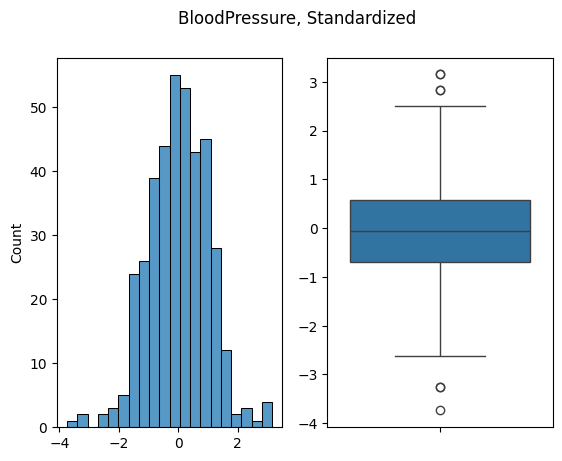

SkinThickness
min 7.0 
max 63.0 
mean 29.145408163265305 
median 29.0 
var 110.3130401395252
Low outliers: 0 High outliers: 3 Tot: 3 Percent: 0.008


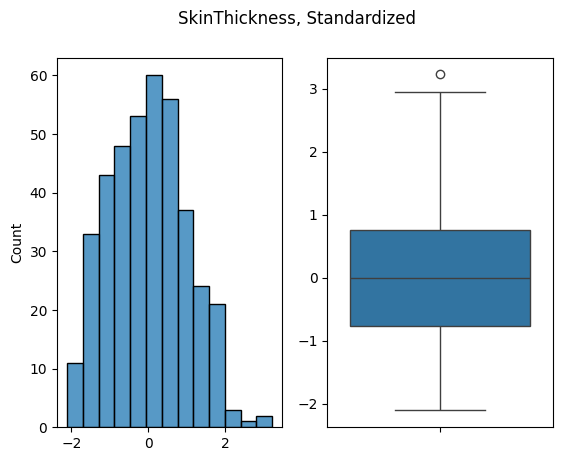

Insulin
min 14.0 
max 846.0 
mean 156.05612244897958 
median 125.5 
var 14087.318278842149
Low outliers: 0 High outliers: 37 Tot: 37 Percent: 0.094


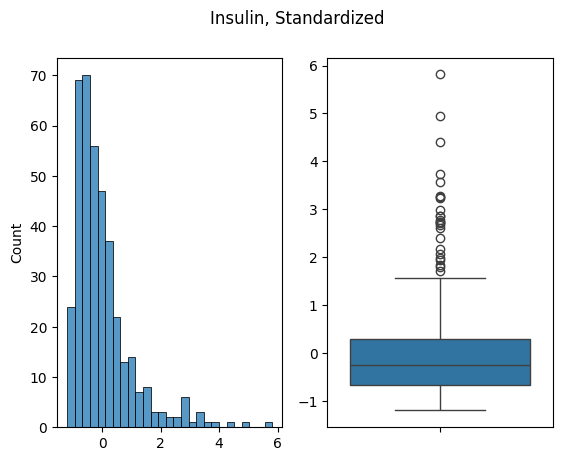

BMI
min 18.2 
max 67.1 
mean 33.08622448979592 
median 33.2 
var 49.26200411286964
Low outliers: 7 High outliers: 15 Tot: 22 Percent: 0.056


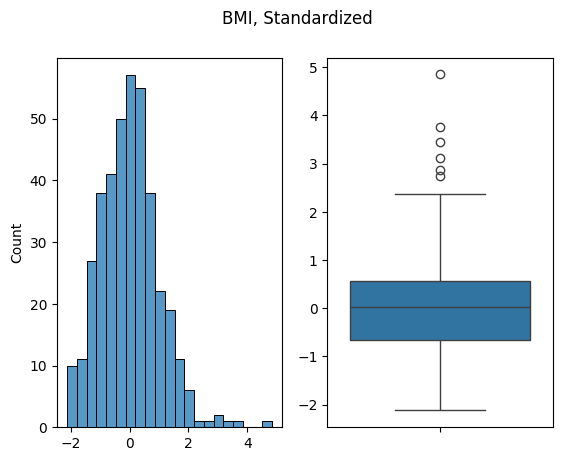

DiabetesPedigreeFunction
min 0.085 
max 2.42 
mean 0.5230459183673469 
median 0.4495 
var 0.11905749278946272
Low outliers: 0 High outliers: 23 Tot: 23 Percent: 0.059


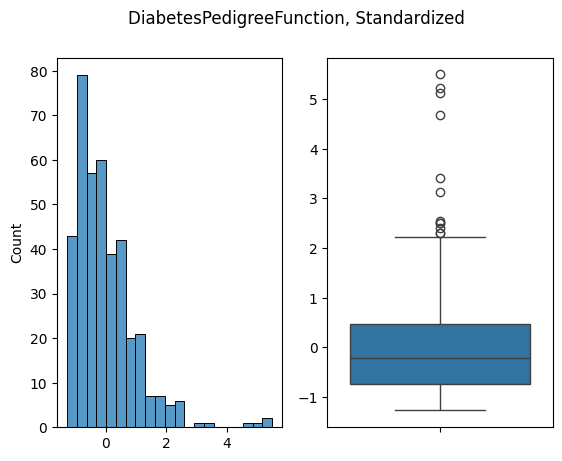

Age
min 21 
max 81 
mean 30.864795918367346 
median 27.0 
var 103.79039332569765
Low outliers: 0 High outliers: 32 Tot: 32 Percent: 0.082


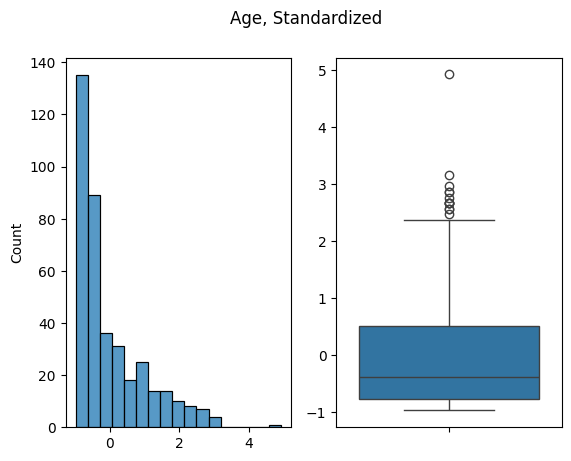

In [423]:
from scipy.stats import iqr

data_details_df = pd.DataFrame({
    'Attribute' : features,
    'Min' : [min(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Max' : [max(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Mean' : [np.mean(new_df[features[i]]) for i in range(len(x.T))]    ,
    'Median' : [np.median(new_df[features[i]]) for i in range(len(x.T))]  ,
    'Variance' : [np.var(new_df[features[i]]) for i in range(len(x.T))]   ,
    'Q1' : [np.quantile(new_df[features[i]],0.25) for i in range(len(x.T))] ,
    'Q3' : [np.quantile(new_df[features[i]],0.75) for i in range(len(x.T))] 
})

# table = plt.table(cellText=data_details_df.values.T,
#                   rowLabels=data_details_df.keys().T,
#                   colLabels=df.columns.T,
#                   loc='center')
# print(data_details_df.to_latex())

for i, att in enumerate(x.T):
    print(features[i])
    print('min', min(new_df[features[i]]), '\nmax', max(new_df[features[i]]), '\nmean', np.mean(new_df[features[i]])    
          , '\nmedian',  np.median(new_df[features[i]]), '\nvar', np.var(new_df[features[i]]))
    iqr_data = iqr(att)
    q1, q3 = np.quantile(att,0.25), np.quantile(att,0.75) 
    thresh_low, thresh_high = q1 - iqr_data, q3 + iqr_data
    out_low, out_high = 0,0
    for obs in att:
        if obs < thresh_low: out_low +=1
        if obs > thresh_high: out_high += 1
    print('Low outliers:', out_low, 'High outliers:', out_high, 'Tot:', out_high+out_low, 
          'Percent:', np.round((out_low+out_high)/len(att),3))
    fig, axes = plt.subplots(1,2)
    sns.histplot(att, ax=axes.flatten()[0])
    sns.boxplot(att, ax=axes.flatten()[1])
    fig.suptitle(f'{features[i]}, Standardized')
    plt.show()


In [424]:
# PCA

pca = PCA()
principalComponents = pca.fit_transform(x)
len(principalComponents.T)

8

In [425]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = [f'principal component {i+1}' for i in range(len(principalComponents.T))])

[0.31994031 0.19459756 0.14984544 0.11946188 0.09002175 0.05017765
 0.03888422 0.03707119]
0.6643833152134104


8.020460358056269

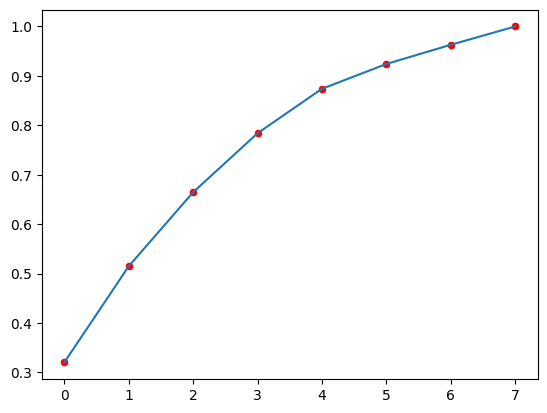

In [426]:
print(pca.explained_variance_ratio_)
plt.figure()
sns.lineplot(np.cumsum(pca.explained_variance_ratio_))
sns.scatterplot(np.cumsum(pca.explained_variance_ratio_), color='r')
print(sum(pca.explained_variance_ratio_[:3]))
sum(pca.explained_variance_)

C:\Users\pvest\AppData\Local\Temp\ipykernel_38600\1683950960.py:5: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



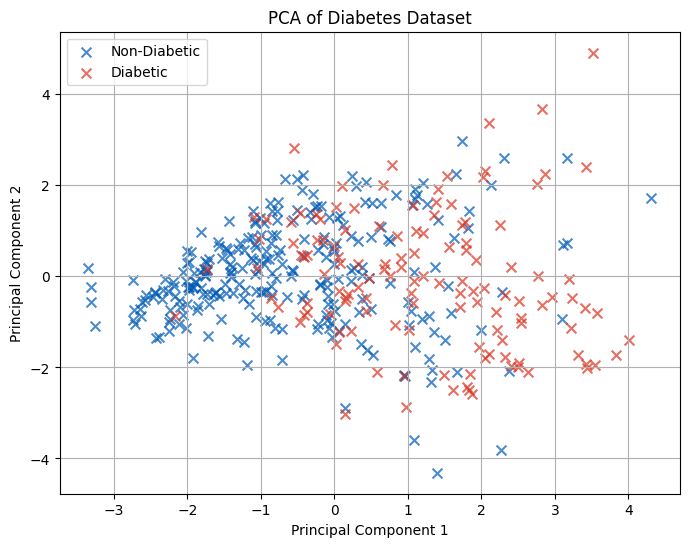

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


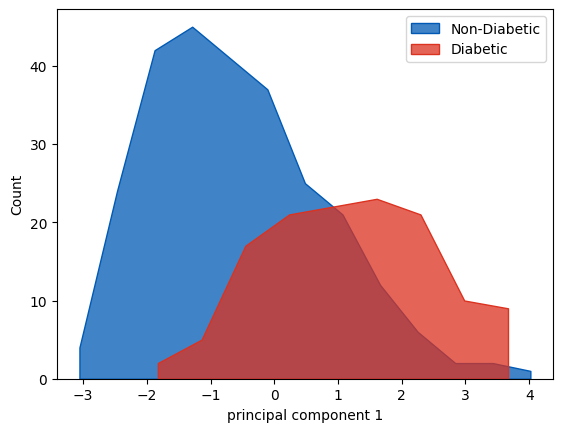

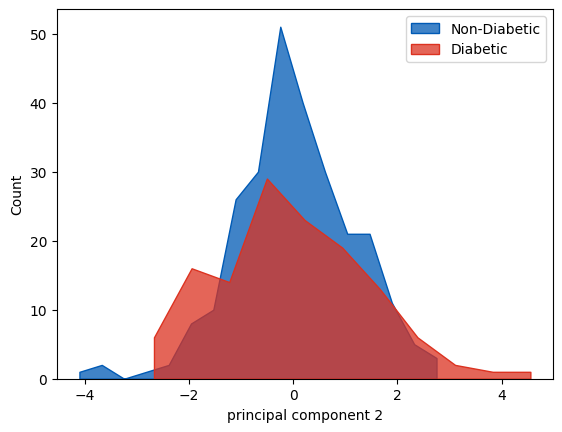

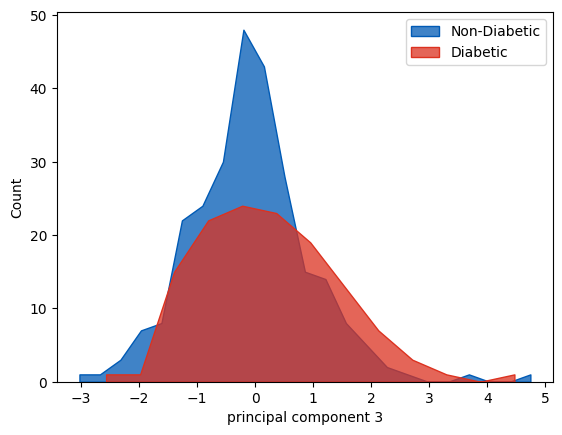

In [427]:
plt.figure(figsize=(8, 6))

for outcome, color in zip([0, 1], ["#005AB5","#DC3220"]):
    indicesToKeep = new_df['Outcome'] == outcome
    plt.scatter(principalDf.loc[indicesToKeep, 'principal component 1'],
                principalDf.loc[indicesToKeep, 'principal component 2'],
                c=color, edgecolor='k', alpha=0.7, s=50, marker='x',
                label=('Non-Diabetic' if outcome == 0 else 'Diabetic'))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Diabetes Dataset')
plt.grid(True)
plt.legend()
plt.show()
print(features)

for i in range(min(len(principalComponents.T), 3)):
    plt.figure()
    sns.histplot(principalDf.loc[new_df['Outcome'] == 0, f'principal component {i+1}'], color="#005AB5", 
                label='Non-Diabetic', element='poly')
    sns.histplot(principalDf.loc[new_df['Outcome'] == 1, f'principal component {i+1}'], color="#DC3220", 
                label='Diabetic', legend=True,element='poly')
    plt.legend()
    plt.show()

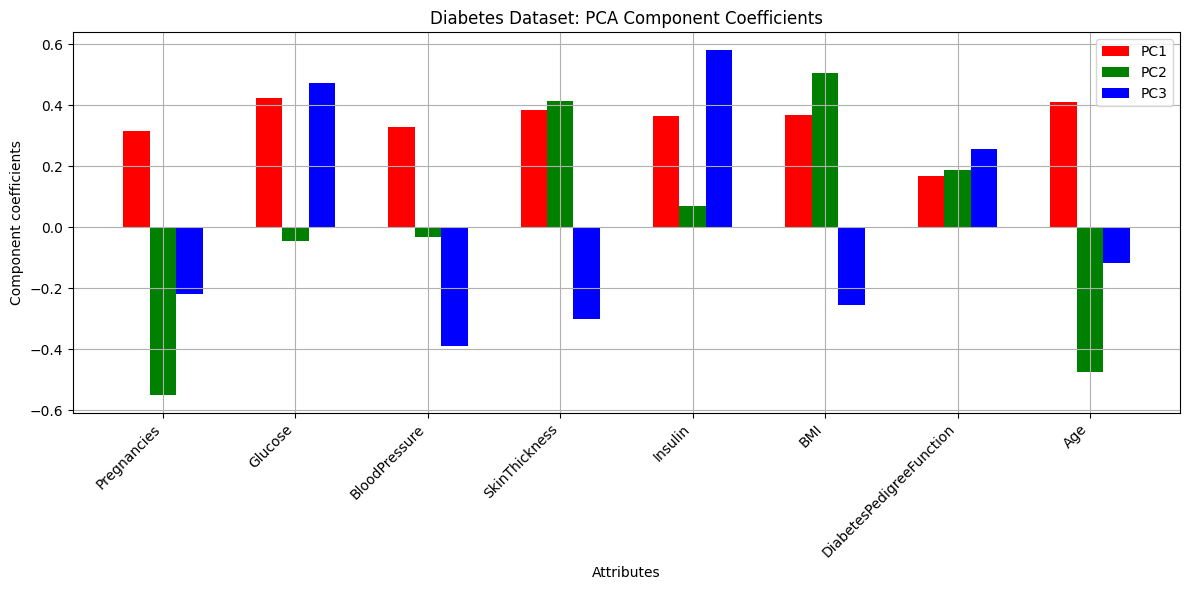

[0.31459005 0.42433171 0.32957685 0.38284835 0.3648862  0.3677518
 0.16737061 0.41156493] 
 [-0.5519162  -0.04691165 -0.0310265   0.41288424  0.06771988  0.50463924
  0.1882636  -0.47651005] 
 [-0.21849279  0.47389479 -0.39071857 -0.30243304  0.58184163 -0.25640534
  0.25560994 -0.1180596 ]


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [428]:
Y = x - np.ones((x.shape[0], 1)) * x.mean(0)
U, S, Vh = svd(Y, full_matrices=False)
V = Vh.T

new_new_df = new_df.drop([col for col in drop_coloumns], axis=1)
attributeNames = list(new_new_df.columns)

pcs = [0, 1, 2]
legendStrs = ["PC" + str(e + 1) for e in pcs]
bw = 0.2
r = np.arange(1, len(attributeNames) + 1)
colors = ["r", "g", "b"]  

plt.figure(figsize=(12, 6))
for i in pcs:
    plt.bar(r + i * bw, V[:, i], width=bw, color=colors[i])
plt.xticks(r + bw, attributeNames, rotation=45, ha="right")
plt.xlabel("Attributes")
plt.ylabel("Component coefficients")
plt.legend(legendStrs)
plt.grid()
plt.title("Diabetes Dataset: PCA Component Coefficients")
plt.tight_layout()  
plt.show()
print(Vh[0],'\n', Vh[1], '\n', Vh[2])
attributeNames

Text(0, 0.5, 'PC2')

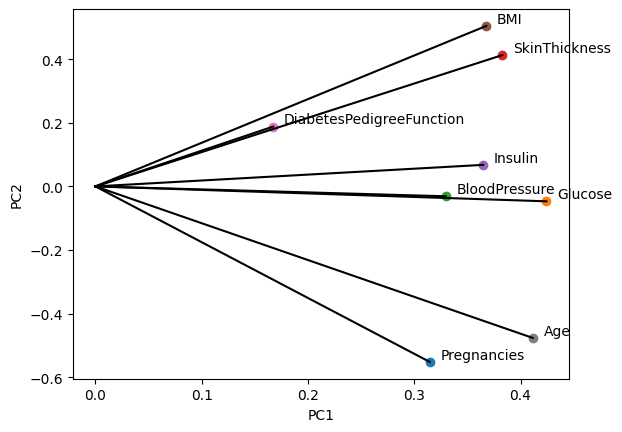

In [433]:
plt.figure()
for i, att in enumerate(attributeNames):
    x = Vh[0,i]
    y = Vh[1,i]
    plt.scatter(x, y, marker = 'o')

    # V this adds the lines V
    plt.plot([0,x], [0, y], color="black")
    # ^ this adds the lines ^

    plt.plot(x,y,0,0, linestyle = '--' )
    plt.text(x+0.01, y+0.01, att, fontsize=10)
plt.xlabel('PC1')
plt.ylabel('PC2')

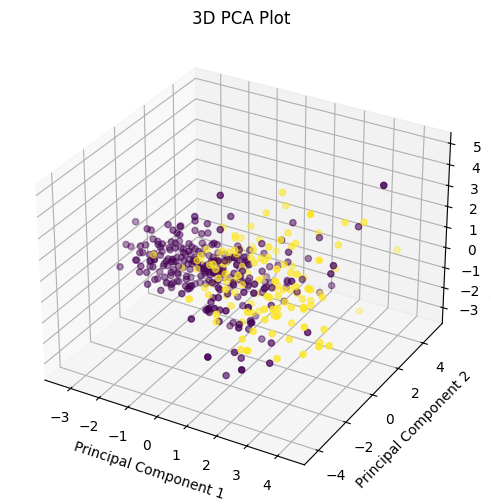

In [ ]:
# Plotting 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extracting the values for each component
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']
colors = new_df['Outcome']

# Plotting
ax.scatter(x_values, y_values, z_values, c = colors, cmap='viridis', marker='o')

# Adding labels for each axis
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Title
ax.set_title('3D PCA Plot')

# Show plot
plt.show()

In [ ]:
x_values = principalDf['principal component 1']
y_values = principalDf['principal component 2']
z_values = principalDf['principal component 3']
colors = new_df['Outcome'] 

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_values,
    y=y_values,
    z=z_values,
    mode='markers',
    marker=dict(
        size=5,
        color=colors,                
        colorscale='Viridis',  
        opacity=0.8
    )
)])


fig.update_layout(
    title='3D PCA Plot',
    scene = dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    margin=dict(r=0, b=0, l=0, t=0)  
)


fig.show()
